# **<span style="color:red">Imports</span>**

In [ ]:
# Math
import math
# Handy arrays
import numpy as np
# FFTs
import scipy.fft as fft
import scipy.fftpack as fftp

# Custom modules
import lib.utils.utils as Utils
import lib.utils.plotting as Plotting
import lib.utils.otf as OTF

# **<span style="color:red">Notes</span>**

## **<span style="color:orange">Window functions</span>**

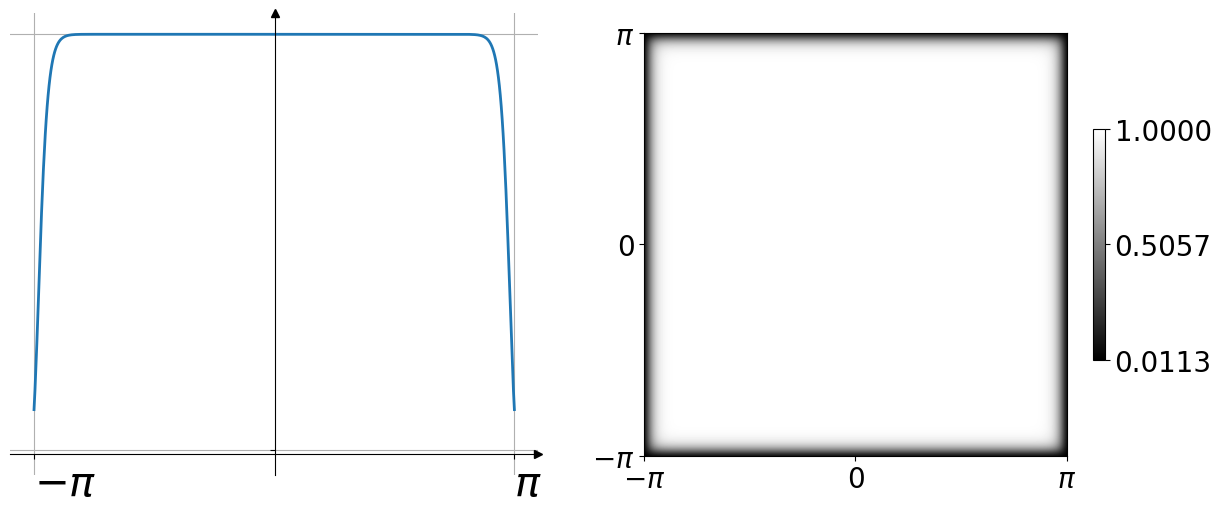

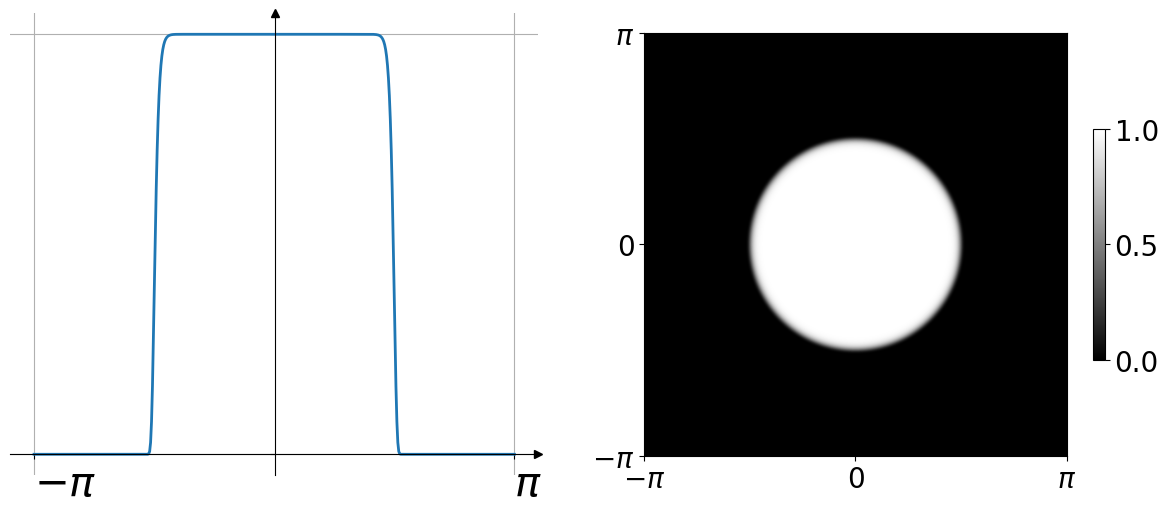

In [2]:
shape = (512,512)

window_func = Utils.create_super_gauss(shape, 10.8/11, 7, mode='square')
Plotting.plot_image(window_func, plot_cut=True, cut_index=256)

window_func = Utils.create_super_gauss(shape, 1/2, 7)
Plotting.plot_image(window_func, plot_cut=True, cut_index=256)

## **<span style="color:orange">Poisson noise</span>**

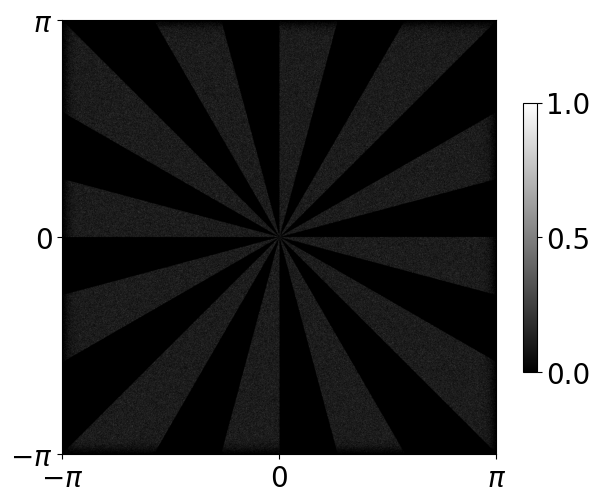

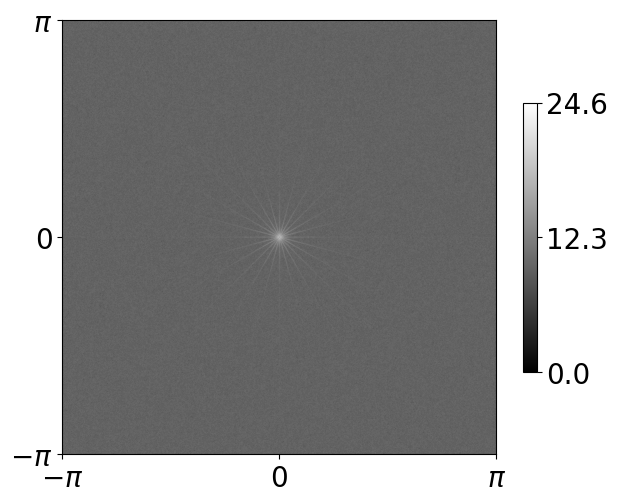

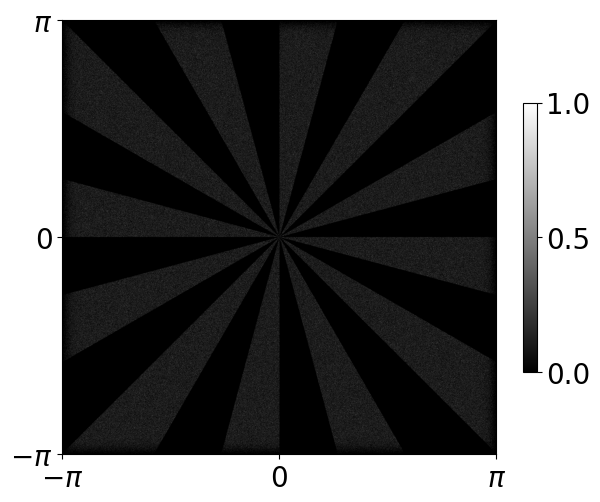

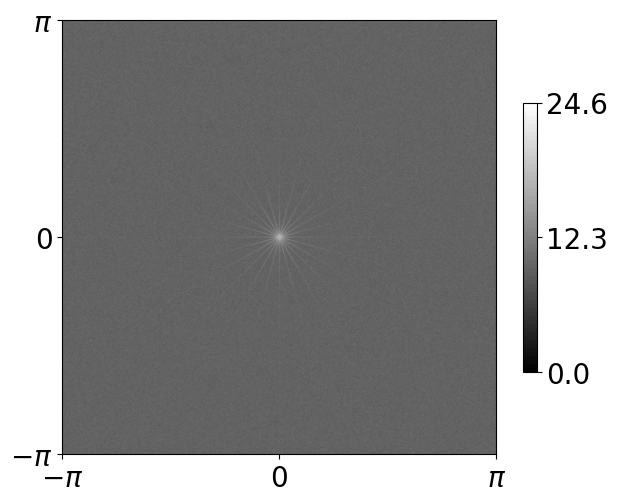

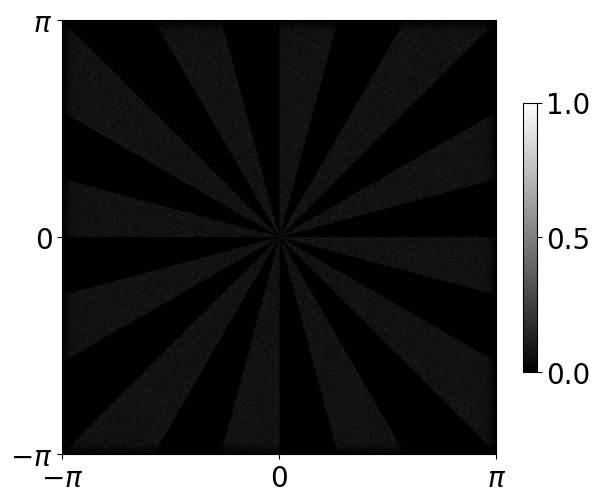

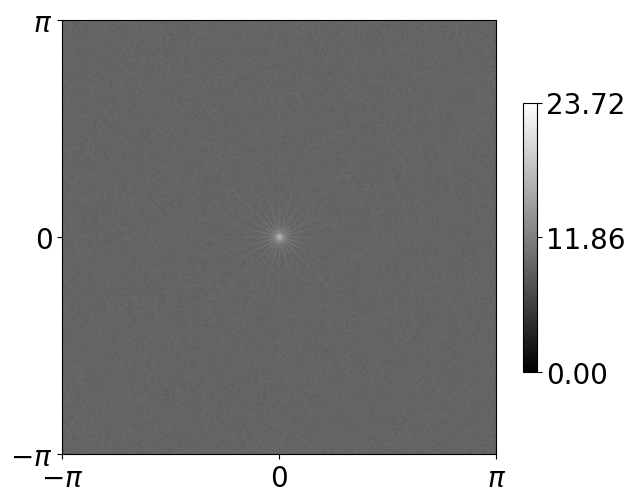

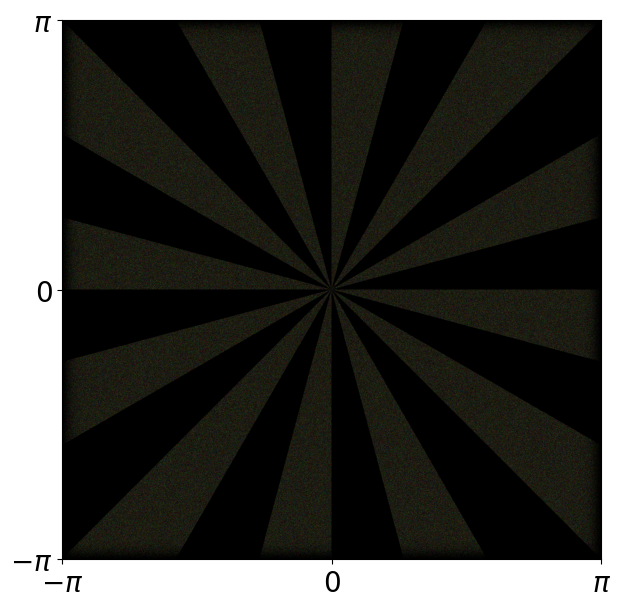

In [ ]:
# Generated image
image = Utils.create_image((2048, 2048), mode='rgb')
image[:,:,2] *= 0.5
window_func = Utils.create_super_gauss(image.shape[0:2], 10.8/11, 10, mode='square')
image = Utils.rgb_mul_mono(image, window_func)

# Poisson noise
poisson_noise_r = np.random.poisson(image[:, :, 0])
poisson_noise_r = Utils.image_normalize(poisson_noise_r)
Plotting.plot_image(poisson_noise_r)
Plotting.plot_spectrum(poisson_noise_r)
poisson_noise_g = np.random.poisson(image[:, :, 1])
poisson_noise_g = Utils.image_normalize(poisson_noise_g)
Plotting.plot_image(poisson_noise_g)
Plotting.plot_spectrum(poisson_noise_g)
poisson_noise_b = np.random.poisson(image[:, :, 2])
poisson_noise_b = Utils.image_normalize(poisson_noise_b)
Plotting.plot_image(poisson_noise_b)
Plotting.plot_spectrum(poisson_noise_b)
poisson_noise = np.stack((poisson_noise_r, poisson_noise_g, poisson_noise_b), axis=-1)
Plotting.plot_image(poisson_noise)
#Utils.image_save(poisson_noise, 'Samples/Test_noise_2_p.png')

In [4]:
im = fftp.fftshift(Utils.get_spectrum(fft.fft2(image[:, :, 0])))
poi = fftp.fftshift(Utils.get_spectrum(fft.fft2(poisson_noise_r)))
Utils.image_save(im, 'Results_(Mag)/Image R Spec.png')
Utils.image_save(poi, 'Results_(Mag)/Poisson Noise R Spec.png')

## **<span style="color:orange">PSF and OTF</span>**

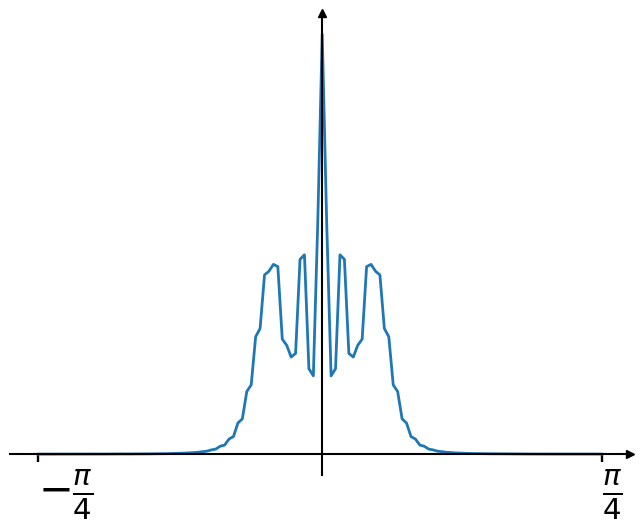

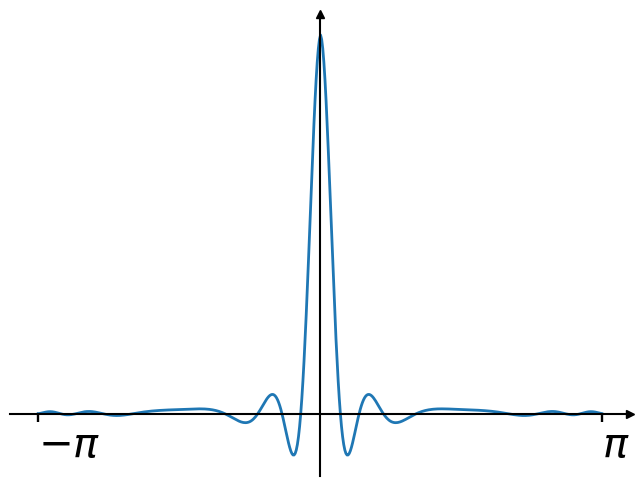

In [2]:
a=1.5
wlength=6
wlength0=10
folder = f'Results_(Mag)/PSF-OTF ({a}, {wlength}, {wlength0})/'

psf = OTF.create_psf((512, 512), a * (wlength - wlength0))
otf = OTF.psf2otf(psf)

psf_cropped = Utils.image_crop_corners(fftp.fftshift(psf), ratio=0.375)
Plotting.plot_image(psf_cropped, axes_labels=[r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$'], plot_image=False,
                    plot_cut=True, cut_index=(psf_cropped.shape[0]//2),
                    plot_file=folder+'1, PSF.svg')
Plotting.plot_image(fftp.fftshift(otf.real), axes_labels=[r'$-\pi$', 0, r'$\pi$'], plot_image=False,
                    plot_cut=True, y_axis_position=-0.5, cut_index=(otf.shape[0]//2),
                    plot_file=folder+'2, OTF.svg')

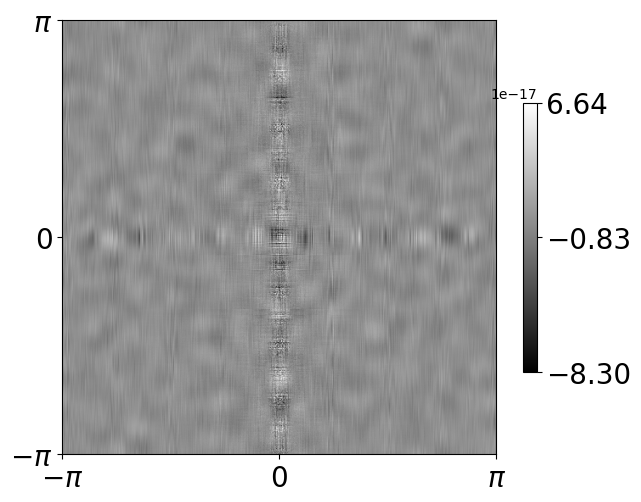

In [3]:
Plotting.plot_image(fftp.fftshift(otf.imag))

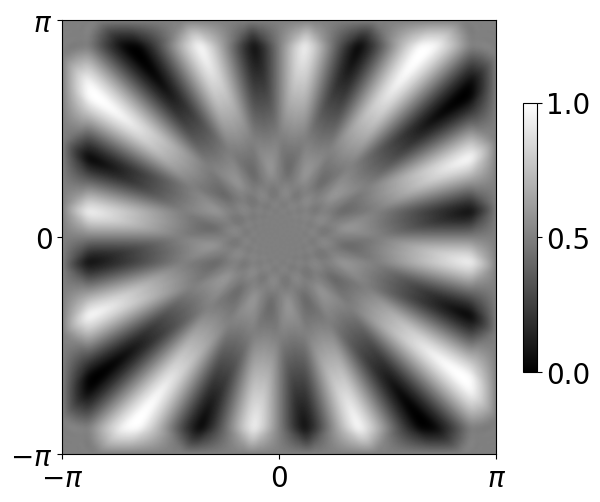

In [ ]:
image = Utils.create_image((512, 512))

# Real part of IFFT from multiplication of image FFT and OTF multiplication
image_blurred = (fft.ifft2(fft.fft2(image) * otf)).real
# Normalize image
image_blurred = Utils.image_normalize(image_blurred)

Plotting.plot_image(image_blurred)
Utils.image_save(image_blurred, folder+'3, blurred image.png')

## **<span style="color:orange">Detector functions adjusted by light source</span>**

In [9]:
detector_funcs = np.loadtxt("Data/detector_funcs.csv", delimiter=";")

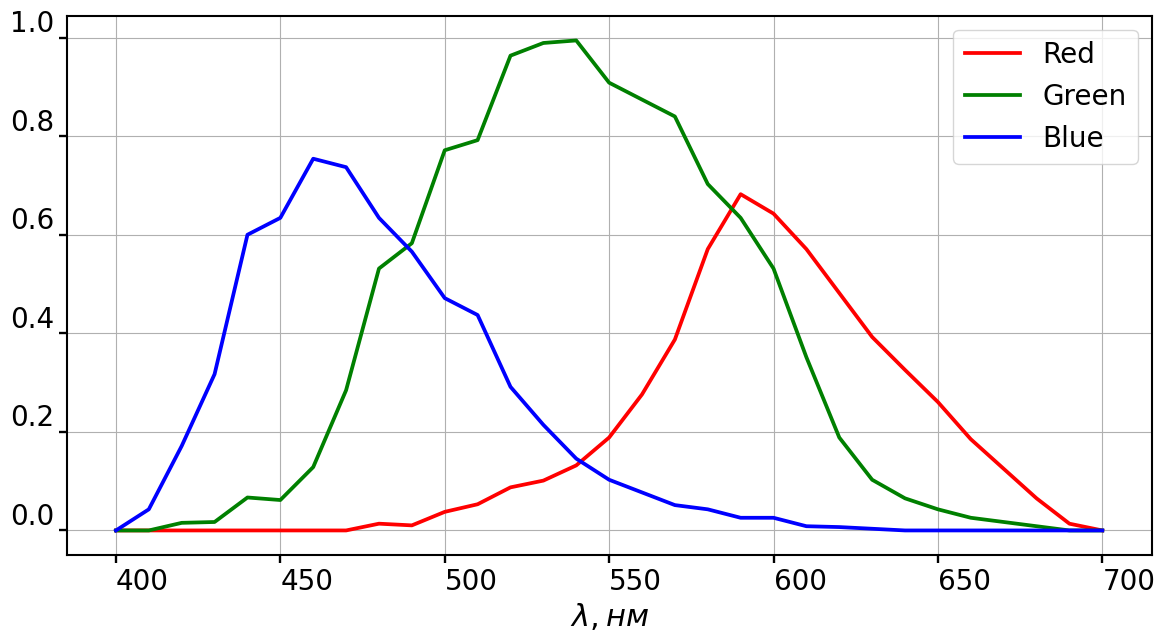

In [10]:
Plotting.plot_functions([Plotting.FuncDesc(detector_funcs[0], detector_funcs[1], 'Red', 'r'),
                         Plotting.FuncDesc(detector_funcs[0], detector_funcs[2], 'Green', 'g'),
                         Plotting.FuncDesc(detector_funcs[0], detector_funcs[3], 'Blue', 'b')],
                        x_axis_name=r'$\lambda, нм$')

In [5]:
h = 6.62607015e-34
k = 1.380649e-23
c = 299792458
T = 2773.15

wlg = detector_funcs[0]
#wlg = np.arange(10, 3000, 10).astype(np.float64) * 1e-9

p1 = 2 * h * c**2
p2 = h*c / (wlg*k*T)
intensity = p1 / ( (wlg**5) * (np.exp(p2) - 1))
intensity /= intensity.max()

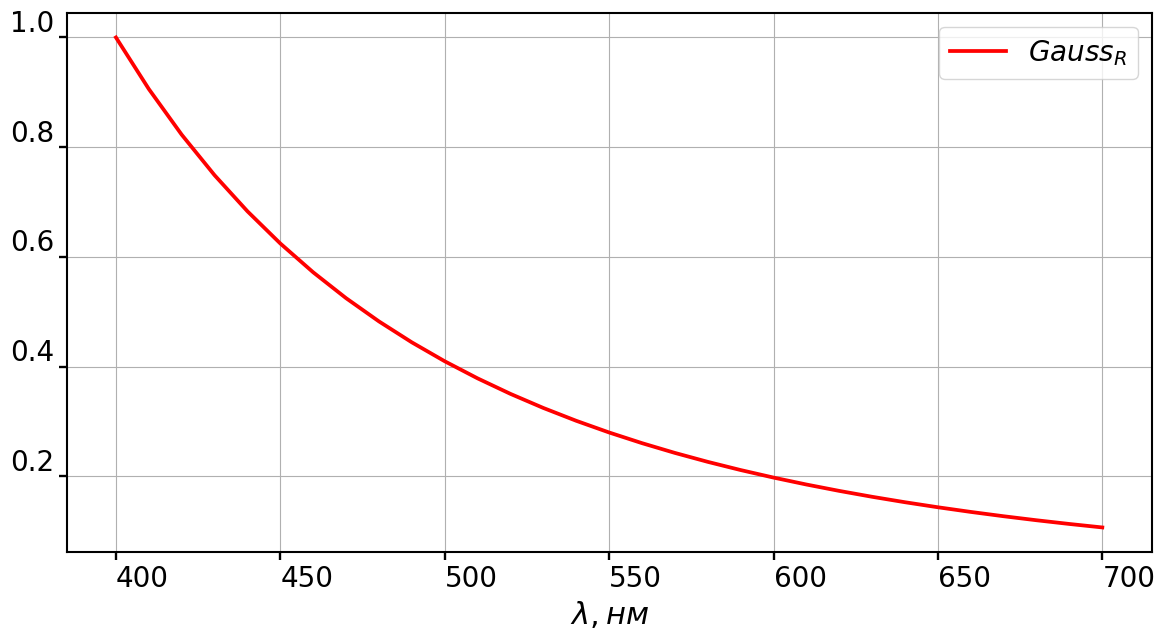

In [6]:
Plotting.plot_functions([Plotting.FuncDesc(wlg, intensity, r'$Gauss_{R}$', 'r')],
                        x_axis_name=r'$\lambda, нм$')

In [7]:
detector_funcs[1] *= intensity
detector_funcs[2] *= intensity
detector_funcs[3] *= intensity

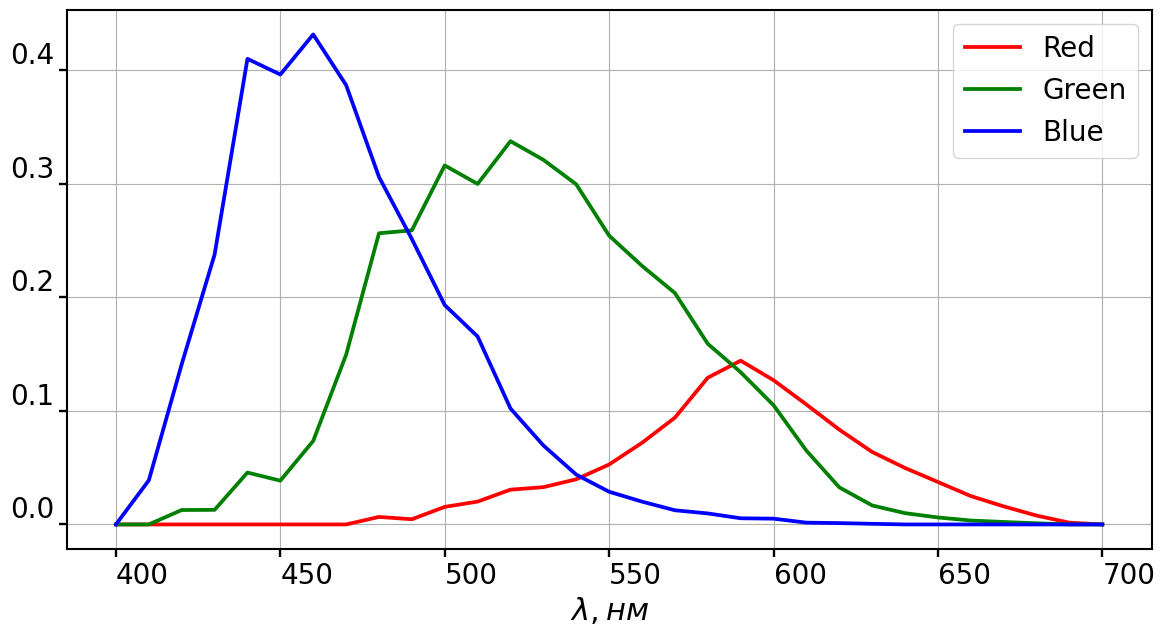

In [8]:
Plotting.plot_functions([Plotting.FuncDesc(detector_funcs[0], detector_funcs[1], 'Red', 'r'),
                         Plotting.FuncDesc(detector_funcs[0], detector_funcs[2], 'Green', 'g'),
                         Plotting.FuncDesc(detector_funcs[0], detector_funcs[3], 'Blue', 'b')],
                        x_axis_name=r'$\lambda, нм$')

## **<span style="color:orange">Fast radial OTF evaluation</span>**

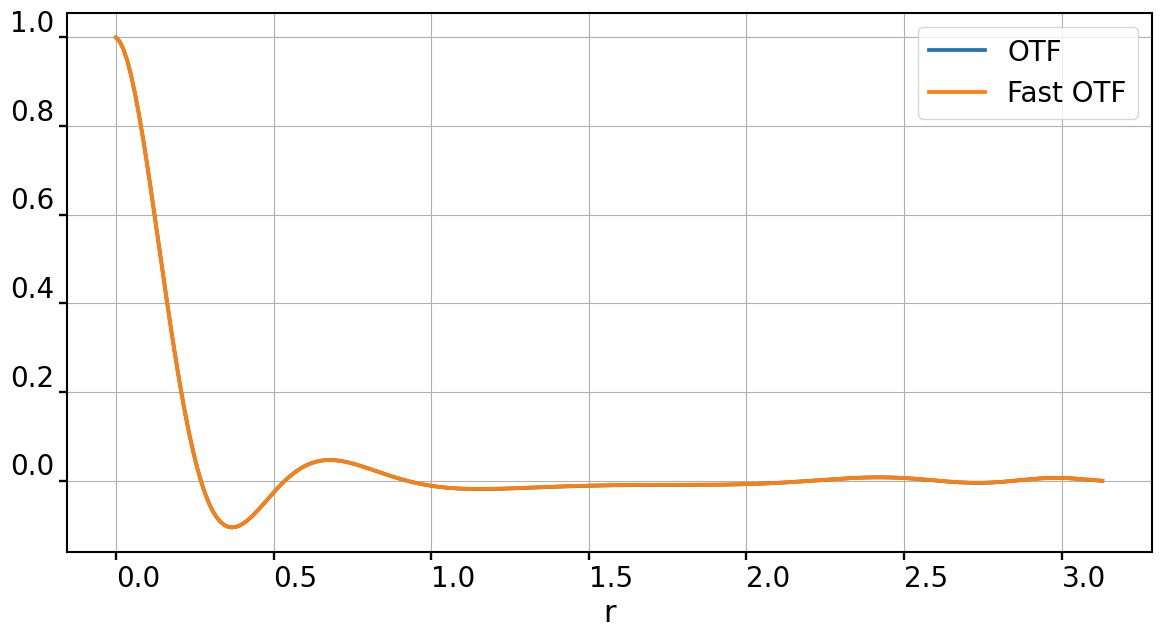

In [2]:
a=5
otf = OTF.create_otf((512, 512), a)

r = np.arange(0, math.pi, math.pi / 256)
otf_slice1 = otf[0:otf.shape[0]//2, 0].real
otf_slice2 = OTF.evaluate_otf_on_grid(r, a)
Plotting.plot_functions([Plotting.FuncDesc(r, otf_slice1, 'OTF'),
                         Plotting.FuncDesc(r, otf_slice2, 'Fast OTF')], x_axis_name='r')

## **<span style="color:orange">Image Metrics</span>**

In [12]:
import lib.utils.metrics as Metrics

In [13]:
img0 = Utils.image_load('Results_(Mag)/Sample_1/1, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_1/3, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_1/5, restored.png', mode='rgb')

In [14]:
print(Metrics.image_dx_grad_norm(img0), Metrics.image_dx_grad_norm(img1), Metrics.image_dx_grad_norm(img2))
print(Metrics.image_dy_grad_norm(img0), Metrics.image_dy_grad_norm(img1), Metrics.image_dy_grad_norm(img2))
print(Metrics.image_dz_grad_norm(img0), Metrics.image_dz_grad_norm(img1), Metrics.image_dz_grad_norm(img2))

0.07278792186304835 0.07044846816993239 0.8794775298889097
0.08062870573178513 0.07177653349605854 0.9078331293569858
0.28080472428290065 0.20631369881359798 0.6674919824641863


In [15]:
img0 = Utils.image_load('Results_(Mag)/Sample_2/1, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_2/3, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_2/5, restored.png', mode='rgb')

In [16]:
print(Metrics.image_dx_grad_norm(img0), Metrics.image_dx_grad_norm(img1), Metrics.image_dx_grad_norm(img2))
print(Metrics.image_dy_grad_norm(img0), Metrics.image_dy_grad_norm(img1), Metrics.image_dy_grad_norm(img2))
print(Metrics.image_dz_grad_norm(img0), Metrics.image_dz_grad_norm(img1), Metrics.image_dz_grad_norm(img2))

0.07278792186304835 0.06759612846707738 1.1382371994931662
0.08062870573178513 0.06786540199025629 1.1360952641083926
0.28080472428290065 0.218676320455992 0.47601796810080266


In [17]:
img0 = Utils.image_load('Results_(Mag)/Sample_3/1, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_3/3, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_3/5, restored.png', mode='rgb')

In [18]:
print(Metrics.image_dx_grad_norm(img0), Metrics.image_dx_grad_norm(img1), Metrics.image_dx_grad_norm(img2))
print(Metrics.image_dy_grad_norm(img0), Metrics.image_dy_grad_norm(img1), Metrics.image_dy_grad_norm(img2))
print(Metrics.image_dz_grad_norm(img0), Metrics.image_dz_grad_norm(img1), Metrics.image_dz_grad_norm(img2))

0.07729727862148787 0.07438252800636712 0.42719179742207913
0.08663533244386269 0.08037904207519048 0.43117573953133903
0.9252115277799986 0.9747868934177324 0.6272154284928796


In [19]:
img0 = Utils.image_load('Results_(Mag)/Sample_5/6, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_5/7, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_5/8, restored.png', mode='rgb')

In [20]:
print(Metrics.image_dx_grad_norm(img0), Metrics.image_dx_grad_norm(img1), Metrics.image_dx_grad_norm(img2))
print(Metrics.image_dy_grad_norm(img0), Metrics.image_dy_grad_norm(img1), Metrics.image_dy_grad_norm(img2))
print(Metrics.image_dz_grad_norm(img0), Metrics.image_dz_grad_norm(img1), Metrics.image_dz_grad_norm(img2))

0.09654736070523369 0.09209365955974239 0.7329897986434855
0.10387972174171954 0.09218948663138075 0.7346221446161991
2.800229605302336 2.6909566125700435 4.184241850918581


In [131]:
img0 = Utils.image_load('Results_(Mag)/Sample_1/6, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_1/7, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_1/8, restored.png', mode='rgb')

In [132]:
print(Metrics.compare_images_mse(img0, img1), Metrics.compare_images_mse(img0, img2))

0.03130334119970444 0.05109389368407071


In [133]:
print(Metrics.compare_images_psnr(img0, img1), Metrics.compare_images_ssim(img0, img2))

15.044093050365783 0.1025784021331698


In [134]:
print(Metrics.compare_images_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img1[:, :, 0])), Metrics.compare_images_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img2[:, :, 0])))

0.3635972000557723 0.1022475528044621


In [135]:
print(Metrics.compare_images_cw_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img1[:, :, 0])), Metrics.compare_images_cw_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img2[:, :, 0])))

0.5951224550505378 0.6118093275413674


In [136]:
img0 = Utils.image_load('Results_(Mag)/Sample_2/6, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_2/7, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_2/8, restored.png', mode='rgb')

In [137]:
print(Metrics.compare_images_mse(img0, img1), Metrics.compare_images_mse(img0, img2))

0.036812035972612935 0.06289941725370399


In [138]:
print(Metrics.compare_images_psnr(img0, img1), Metrics.compare_images_ssim(img0, img2))

14.340101622539855 0.1610695162094329


In [139]:
print(Metrics.compare_images_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img1[:, :, 0])), Metrics.compare_images_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img2[:, :, 0])))

0.3659653023187219 0.08931351527132961


In [140]:
print(Metrics.compare_images_cw_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img1[:, :, 0])), Metrics.compare_images_cw_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img2[:, :, 0])))

0.5734644620234225 0.41820931218199997


In [141]:
img0 = Utils.image_load('Results_(Mag)/Sample_5/6, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_5/7, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_5/8, restored.png', mode='rgb')

In [142]:
print(Metrics.compare_images_mse(img0, img1), Metrics.compare_images_mse(img0, img2))

0.0011226306959736443 0.027206044307284707


In [143]:
print(Metrics.compare_images_psnr(img0, img1), Metrics.compare_images_ssim(img0, img2))

29.49763087085424 0.25413747568398787


In [144]:
print(Metrics.compare_images_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img1[:, :, 0])), Metrics.compare_images_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img2[:, :, 0])))

0.20347731469056793 0.05450433407432344


In [145]:
print(Metrics.compare_images_cw_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img1[:, :, 0])), Metrics.compare_images_cw_ssim(Utils.image_normalize(img0[:, :, 0]), Utils.image_normalize(img2[:, :, 0])))

0.429792716371838 0.4090594693167243


In [146]:
img0 = Utils.image_load('Results_(Mag)/Sample_3/1, original.png', mode='rgb')
img1 = Utils.image_load('Results_(Mag)/Sample_3/3, observed.png', mode='rgb')
img2 = Utils.image_load('Results_(Mag)/Sample_3/5, restored.png', mode='rgb')